# Imports

In [1]:
#!pip install -U scikit-learn

In [2]:
from Transformation import Transformation
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [3]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [4]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [5]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [6]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [7]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[30.93724966 30.94521701 30.93732685 ...  9.7192176  27.88976863
  9.72086071]
[25.61269841 25.61929452 25.61276232 ...  8.04646153 23.08971355
  8.04782184]
[1.         1.         1.         ... 0.99868675 0.99999999 0.99868822]
(5999,)


### Multinomial Sampling

In [8]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 0 0 ... 0 0 0]


In [9]:
target_number_triangles = 10
target_number_point = min(len(graph._node), target_number_triangles*3)   # number of points for the simplification     #TODO Change to nb of triangles

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(89.292534, 6.7292814, 83.463715), (80.27039, -8.798424, -3.454077), (89.39142, 6.7292814, 82.7126), (83.196976, 7.138877, 92.48217), (82.519966, -8.798424, -1.0835235), (75.0, -3.2518802, 81.82288), (85.23232, 6.7292814, 91.43233), (78.60937, 7.138877, 94.67034), (87.07718, 7.138877, 88.17276), (76.89767, -5.5423326, 3.2915213), (86.77158, -5.2797017, -6.7991786), (92.47266, 1.4916434, 42.5), (87.962585, 1.6554987, 92.87156), (63.0, -3.0965528, 98.23719), (75.79908, -5.5423326, 2.005239), (91.64078, 3.5589852, 1.1643598), (87.47566, -5.7970243, -5.264097), (75.011826, 1.9813722, 81.42565), (75.0, -1.6554987, -13.642877), (75.39972, -8.722893, 88.82714), (76.661125, 5.145526, 68.3), (82.519966, 8.798424, -1.0835235), (81.07934, -7.5075808, -8.131366), (77.13215, -6.9390492, 1.1670189), (84.78793, -8.672658, 0.6197073), (82.13551, -0.99710757, 97.22662), (84.86098, 7.138877, 91.060974), (76.29851, -8.78582, -4.398447), (77.003914, -7.8332825, 93.852234), (89.89532, 5.7970243, 85.191185

# KNN

In [10]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[89.292534, 6.7292814, 83.463715], [80.27039, -8.798424, -3.454077], [89.39142, 6.7292814, 82.7126], [83.196976, 7.138877, 92.48217], [82.519966, -8.798424, -1.0835235], [75.0, -3.2518802, 81.82288], [85.23232, 6.7292814, 91.43233], [78.60937, 7.138877, 94.67034], [87.07718, 7.138877, 88.17276], [76.89767, -5.5423326, 3.2915213], [86.77158, -5.2797017, -6.7991786], [92.47266, 1.4916434, 42.5], [87.962585, 1.6554987, 92.87156], [63.0, -3.0965528, 98.23719], [75.79908, -5.5423326, 2.005239], [91.64078, 3.5589852, 1.1643598], [87.47566, -5.7970243, -5.264097], [75.011826, 1.9813722, 81.42565], [75.0, -1.6554987, -13.642877], [75.39972, -8.722893, 88.82714], [76.661125, 5.145526, 68.3], [82.519966, 8.798424, -1.0835235], [81.07934, -7.5075808, -8.131366], [77.13215, -6.9390492, 1.1670189], [84.78793, -8.672658, 0.6197073], [82.13551, -0.99710757, 97.22662], [84.86098, 7.138877, 91.060974], [76.29851, -8.78582, -4.398447], [77.003914, -7.8332825, 93.852234], [89.89532, 5.7970243, 85.191185

In [11]:
def connect_extended_graph(XYZ, number_neigh=15):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [12]:
extended_graph = connect_extended_graph(XYZ)

Number of nodes: 30
Number of edges: 272


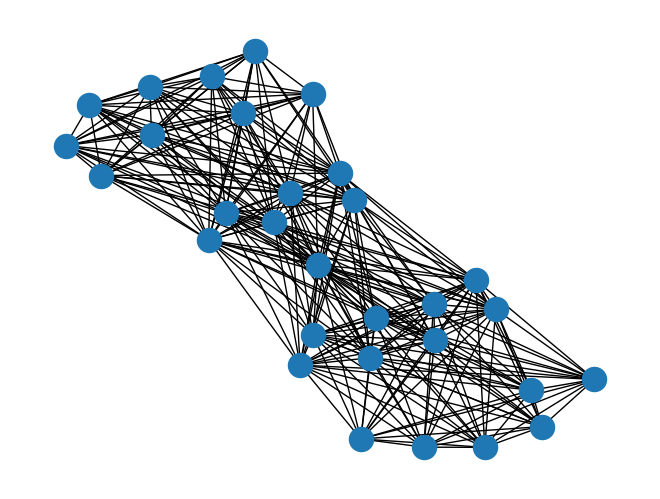

In [13]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [14]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(30, 64)


In [15]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean


f1i = np.mean(inclusion_score)
f1j = np.mean(inclusion_score)
wq = np.random.randint(100, size=(64,1))
wk = np.random.randint(100, size=(1,64))

f1i_wq = f1i*wq
f1j_wk = f1j*wk

wq_wk = int(np.matmul(f1j_wk, f1i_wq)) 

expo = np.exp(wq_wk)



C:\Users\Arthur\AppData\Local\Temp\ipykernel_11368\73126498.py:21: RuntimeWarning: overflow encountered in exp
  expo = np.exp(wq_wk)


### Sparse Attention

# Face Candidates

#### Inputs

In [16]:
adjacency = nx.adjacency_matrix(extended_graph)
S = np.random.rand(target_number_point, target_number_point)
print(adjacency)
print(S)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1
  (0, 16)	1
  (0, 19)	1
  (0, 20)	1
  (0, 21)	1
  (0, 24)	1
  (0, 26)	1
  (0, 27)	1
  (0, 28)	1
  (0, 29)	1
  (1, 0)	1
  (1, 2)	1
  :	:
  (28, 17)	1
  (28, 18)	1
  (28, 19)	1
  (28, 20)	1
  (28, 21)	1
  (28, 22)	1
  (28, 23)	1
  (28, 24)	1
  (28, 25)	1
  (28, 26)	1
  (28, 27)	1
  (29, 0)	1
  (29, 1)	1
  (29, 2)	1
  (29, 3)	1
  (29, 4)	1
  (29, 5)	1
  (29, 6)	1
  (29, 7)	1
  (29, 8)	1
  (29, 9)	1
  (29, 10)	1
  (29, 11)	1
  (29, 13)	1
  (29, 14)	1
[[9.28062632e-01 9.48088872e-01 6.09805385e-01 6.10429628e-01
  8.07227864e-01 6.40120826e-02 4.16191152e-01 1.94075666e-01
  9.80391955e-01 3.70037054e-01 2.66065905e-01 2.97933276e-01
  4.79012724e-01 6.71181305e-01 8.38566415e-01 1.77643474e-01
  6.45552835e-01 1.79423796e-01 4.27172634e-01 3.61350196e-01
  6.05665360e-01 3.92353006e-01 4.51484642e-01 6.91514365e-01
  8.66783803e-01 5

In [17]:
A_s = np.zeros((target_number_point,target_number_point))

for i in range(target_number_point):
    for j in range(target_number_point):
        A_s[i,j] = np.matmul(np.matmul(S[i,:], adjacency.A), S[j,:][np.newaxis].T)

print(A_s)  # symmétrique
print(A_s.shape)

[[153.93012413 124.34189754 169.09555766 136.32543838 158.26873763
  145.59160294 154.12838595 169.18087802 134.03924421 143.66730951
  139.79961293 164.03913205 124.3809264  136.81960768 129.73811656
  153.78414786 163.48595793 124.64137929 139.47713183 114.71182393
  150.11772822 167.99163869 144.50105735 150.18906718 139.6575641
  133.70355969 130.87369192 155.5967268  155.28363262 156.31576587]
 [124.34189754  97.64874327 135.8646296  108.08244782 125.62731099
  116.40956599 121.71100635 134.68325438 106.74908426 115.22789319
  112.58125869 131.42854495  98.19380607 109.08173828 102.55182673
  122.66686084 131.54623981 100.24444395 110.88583507  90.93116627
  120.40173511 134.34549453 117.17496824 120.50533473 111.31217043
  104.77922143 104.07997725 124.82378868 123.33802651 125.03108654]
 [169.09555766 135.8646296  184.01269529 146.99264759 171.99971413
  157.41140476 164.89764804 184.52295875 145.29354443 157.56602733
  153.35898252 177.90973606 133.87766665 148.8050961  140.726

c:\Users\Arthur\miniconda3\envs\meshPFE\lib\site-packages\scipy\sparse\_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


# Face Classifier

### TriConv

#### Inputs

In [18]:
triangles = list(nx.simple_cycles(extended_graph, length_bound=3))  # [triangle0, triangle1,...] | triangle0 = [node1,node2,node3] | node1 = (x ,y ,z)
print(triangles)
print(np.array(triangles).shape)    #nb_triangle, 3 nodes, 3 dimensions par node

[[(89.292534, 6.7292814, 83.463715), (89.39142, 6.7292814, 82.7126), (89.89532, 5.7970243, 85.191185)], [(89.292534, 6.7292814, 83.463715), (89.39142, 6.7292814, 82.7126), (87.07718, 7.138877, 88.17276)], [(89.292534, 6.7292814, 83.463715), (89.39142, 6.7292814, 82.7126), (84.86098, 7.138877, 91.060974)], [(89.292534, 6.7292814, 83.463715), (89.39142, 6.7292814, 82.7126), (85.23232, 6.7292814, 91.43233)], [(89.292534, 6.7292814, 83.463715), (89.39142, 6.7292814, 82.7126), (87.962585, 1.6554987, 92.87156)], [(89.292534, 6.7292814, 83.463715), (89.39142, 6.7292814, 82.7126), (83.196976, 7.138877, 92.48217)], [(89.292534, 6.7292814, 83.463715), (89.39142, 6.7292814, 82.7126), (75.011826, 1.9813722, 81.42565)], [(89.292534, 6.7292814, 83.463715), (89.39142, 6.7292814, 82.7126), (78.60937, 7.138877, 94.67034)], [(89.292534, 6.7292814, 83.463715), (89.39142, 6.7292814, 82.7126), (82.13551, -0.99710757, 97.22662)], [(89.292534, 6.7292814, 83.463715), (89.39142, 6.7292814, 82.7126), (75.0, -3.

In [19]:
p_init = np.zeros((len(triangles)))

for index_triangle, triangle in enumerate(triangles):
    i = list(dict(extended_graph._node).keys()).index(triangle[0])
    j = list(dict(extended_graph._node).keys()).index(triangle[1])
    k = list(dict(extended_graph._node).keys()).index(triangle[2])
    p_init[index_triangle] = (A_s[i,j] + A_s[i,k] + A_s[j,k])/3
print(p_init)

[143.10069494 122.91659458 136.07931539 ... 125.6012659  110.46327064
 128.68516169]


#### Calculate barycenter

In [20]:
barycenters = list()

for _, triangle in enumerate(triangles):
    b_x = (triangle[0][0] + triangle[1][0] + triangle[2][0]) / 3
    b_y = (triangle[0][1] + triangle[1][1] + triangle[2][1]) / 3
    b_z = (triangle[0][2] + triangle[1][2] + triangle[2][2]) / 3
    barycenters.append([b_x, b_y, b_z])

print(barycenters)
print(len(barycenters))

[[89.52642822265625, 6.418528874715169, 83.78916422526042], [88.58704630533855, 6.86581293741862, 84.78302510579427], [87.84830729166667, 6.86581293741862, 85.74576822916667], [87.9720967610677, 6.729281107584636, 85.86954752604167], [88.88218180338542, 5.0380204518636065, 86.3492940266927], [87.29364013671875, 6.86581293741862, 86.21949259440105], [84.56526184082031, 5.146644910176595, 82.5339864095052], [85.76444498697917, 6.86581293741862, 86.94888305664062], [86.9398193359375, 4.153818448384603, 87.80098470052083], [84.56131998697917, 3.4022274017333984, 82.66640218098958], [85.11503092447917, 6.201362609863281, 78.15877278645833], [84.69455973307292, 1.5785566965738933, 85.0011494954427], [85.22928873697917, 1.8750934600830078, 86.67618815104167], [80.56131998697917, 3.45400333404541, 88.13783772786458], [90.38553873697917, 4.983402252197266, 69.55877176920573], [90.10824584960938, 5.672515869140625, 55.78022257486979], [85.19387817382812, 2.6387434005737305, 56.489278157552086], 

In [21]:
def connect_triangle_graph(XYZ, number_neigh=20):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [22]:
graph_triangles = connect_triangle_graph(barycenters)
print(graph_triangles._node)

{(89.52642822265625, 6.418528874715169, 83.78916422526042): {'index_poly': {0, 1, 180, 22}}, (88.58704630533855, 6.86581293741862, 84.78302510579427): {'index_poly': {0, 1, 2, 3, 4, 180, 181, 22, 23, 182}}, (88.78797403971355, 6.555061340332031, 85.35884602864583): {'index_poly': {0, 1, 2, 3, 4, 5, 180, 181, 22, 23, 24, 25, 182, 183}}, (88.7550048828125, 6.555061340332031, 85.60922241210938): {'index_poly': {0, 1, 2, 3, 4, 5, 180, 181, 22, 23, 24, 25, 182, 184, 183}}, (87.9720967610677, 6.729281107584636, 85.86954752604167): {'index_poly': {0, 1, 2, 3, 4, 5, 180, 181, 22, 23, 24, 182, 26, 184, 183}}, (87.84830729166667, 6.86581293741862, 85.74576822916667): {'index_poly': {0, 1, 2, 3, 4, 5, 180, 181, 22, 23, 24, 182, 26, 184}}, (88.04923502604167, 6.555061340332031, 86.3215840657552): {'index_poly': {0, 1, 2, 3, 4, 5, 201, 202, 180, 181, 22, 23, 24, 25, 26, 182, 184, 183}}, (88.88218180338542, 5.0380204518636065, 86.3492940266927): {'index_poly': {0, 1, 2, 3, 4, 203, 180, 181, 22, 23, 

In [23]:
transformation.print_graph_properties(graph=graph_triangles, display_graph=False, display_labels=False)

Number of nodes: 1337
Number of edges: 36467


#### calculate e norm matrix

In [24]:
diff_vectors = list()

for _, triangle in enumerate(triangles):
    e_ij = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[1]))
    e_ik = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[2]))
    e_jk = np.linalg.norm(np.array(triangle[1]) - np.array(triangle[2]))
    diff_vectors.append([e_ij, e_ik, e_jk])
print(diff_vectors)
print(len(diff_vectors))

[[0.757595, 2.0534375, 2.6956255], [0.757595, 5.2202177, 5.9444776], [0.757595, 8.804818, 9.50726], [0.757595, 8.943383, 9.660834], [0.757595, 10.771238, 11.445054], [0.757595, 10.8929405, 11.575118], [0.757595, 15.18667, 15.197749], [0.757595, 15.488263, 16.106146], [0.757595, 17.330254, 17.97226], [0.757595, 17.50978, 17.53648], [0.757595, 19.798962, 19.29486], [0.757595, 21.460342, 21.723833], [0.757595, 21.702528, 22.127132], [0.757595, 31.71908, 32.15691], [0.757595, 41.419464, 40.669155], [0.757595, 82.39386, 81.64084], [0.757595, 82.047585, 81.328926], [0.757595, 84.38389, 83.65199], [0.757595, 83.47544, 82.75882], [0.757595, 84.30566, 83.58704], [0.757595, 84.84329, 84.10285], [0.757595, 86.227684, 85.49923], [2.0534375, 5.2202177, 4.31651], [2.0534375, 8.804818, 7.8485394], [2.0534375, 8.943383, 7.8463035], [2.0534375, 10.771238, 8.937328], [2.0534375, 10.8929405, 9.991337], [2.0534375, 15.18667, 15.819506], [2.0534375, 15.488263, 14.7995825], [2.0534375, 17.330254, 15.850128]

#### Calculate r

In [25]:
r_matrix = np.zeros((len(triangles),len(triangles), 5))

for n, triangle_n in enumerate(triangles):
    for m, triangle_m in enumerate(triangles):
        t_min = min(diff_vectors[n]) - min(diff_vectors[m])
        t_max = max(diff_vectors[n]) - max(diff_vectors[m])
        diff_bary = np.array(barycenters[n]) - np.array(barycenters[m])
        r_matrix[n, m] = [t_min, t_max, diff_bary[0], diff_bary[1], diff_bary[2]]

print(r_matrix)
print(r_matrix.shape)   # nb_triangles, nb_triangles, 5dim/triangles

[[[  0.           0.           0.           0.           0.        ]
  [  0.          -3.24885201   0.93938192  -0.44728406  -0.99386088]
  [  0.          -6.81163502   1.67812093  -0.44728406  -1.956604  ]
  ...
  [ -1.34728098  -8.90153313  11.52290853  13.0815169   85.44220018]
  [ -4.5918355  -25.96590805  13.17150879  10.22207864   0.12937419]
  [ -4.5918355  -13.85604477  17.72521973  12.96943855  -9.84969076]]

 [[  0.           3.24885201  -0.93938192   0.44728406   0.99386088]
  [  0.           0.           0.           0.           0.        ]
  [  0.          -3.56278276   0.73873901   0.          -0.96274312]
  ...
  [ -1.34728098  -5.65268087  10.58352661  13.52880096  86.43606106]
  [ -4.5918355  -22.71705627  12.23212687  10.6693627    1.12323507]
  [ -4.5918355  -10.60719299  16.78583781  13.41672262  -8.85582987]]

 [[  0.           6.81163502  -1.67812093   0.44728406   1.956604  ]
  [  0.           3.56278276  -0.73873901   0.           0.96274312]
  [  0.           

#### Calculate f

In [26]:
# MLP * 3 
f_final = p_init    # TODO

import torch
final_scores = torch.nn.functional.softmax(torch.tensor(f_final))
final_scores = final_scores.numpy()
print(final_scores.sum())
print(final_scores.shape)
print(final_scores)

1.0
(1337,)
[3.55886452e-17 6.10194163e-26 3.17661851e-20 ... 8.94140958e-25
 2.38263864e-31 1.95310196e-23]


C:\Users\Arthur\AppData\Local\Temp\ipykernel_11368\4023725568.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_scores = torch.nn.functional.softmax(torch.tensor(f_final))


# Simplified Mesh

In [27]:
selected_triangles_indexes = np.argpartition(final_scores, -target_number_point)[-target_number_point:] 
selected_triangles = np.array(triangles)[selected_triangles_indexes]
print(selected_triangles.shape) # number triangles, number points, number dimensions(x,y,z)

(30, 3, 3)


In [28]:
def create_triangle_graph(XYZ):
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(XYZ):
        for index_current_node in range(len(poly)):
            current_node = tuple(poly[index_current_node])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(poly[index_other_node])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_triangle'] = set()
                extended_graph.nodes[current_node]['index_triangle'].add(index_poly)
                if len(extended_graph.nodes[tuple(poly[index_other_node])])==0:
                    extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'] = set()
                extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'].add(index_poly)
    return extended_graph

In [29]:
simplified_final_graph = create_triangle_graph(selected_triangles)
print(simplified_final_graph._node)

{(89.89532, 5.7970243, 85.191185): {'index_triangle': {0, 1, 5, 6, 8, 9, 10, 11, 14, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 28, 29}}, (87.962585, 1.6554987, 92.87156): {'index_triangle': {0, 10, 12}}, (75.0, -3.2518802, 81.82288): {'index_triangle': {0, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 20, 21, 22, 27}}, (84.78793, -8.672658, 0.6197073): {'index_triangle': {1}}, (75.79908, -5.5423326, 2.005239): {'index_triangle': {1, 2, 3, 4, 15, 19, 20, 21, 24, 26, 29}}, (82.519966, 8.798424, -1.0835235): {'index_triangle': {2, 17, 21, 23, 24}}, (82.519966, -8.798424, -1.0835235): {'index_triangle': {2, 3, 5, 20, 23, 26, 27, 28}}, (89.292534, 6.7292814, 83.463715): {'index_triangle': {3, 4, 6, 11, 18, 28, 29}}, (92.47266, 1.4916434, 42.5): {'index_triangle': {9, 19, 5}}, (83.196976, 7.138877, 92.48217): {'index_triangle': {6, 7, 10, 12, 13, 14, 16, 18, 25}}, (63.0, -3.0965528, 98.23719): {'index_triangle': {8, 16, 7}}, (84.86098, 7.138877, 91.060974): {'index_triangle': {25, 13, 22}}}


In [30]:
transformation.print_graph_properties(graph=simplified_final_graph, display_graph=False, display_labels=False)

Number of nodes: 12
Number of edges: 32


In [31]:
simplified_final_mesh = transformation.graph_to_mesh(simplified_final_graph)

transformation.mesh_to_display_vtk(mesh_data)
transformation.mesh_to_display_vtk(simplified_final_mesh)